In [1]:
from utils import *

import cellxgene_census
from cellxgene_census.experimental.ml import ExperimentDataPipe, experiment_dataloader
import somacore as soma
from somacore import AxisQuery
import torch
from torch.utils.data import DataLoader
torch.ones(2).cuda();

In [2]:
census = cellxgene_census.open_soma()

#reference = ln.Collection.filter(uid="1gsdckxvOvIjQgeDVS1F").one().reference
reference = '283d65eb-dd53-496d-adb7-7570c7caa443'
query_collection_id = f"collection_id == '{reference}'"
datasets =(census["census_info"]["datasets"]
           .read(column_names=["dataset_id"], value_filter=query_collection_id)
           .concat().to_pandas())["dataset_id"].tolist()
datasets[:10]

The "stable" release is currently 2023-12-15. Specify 'census_version="2023-12-15"' in future calls to open_soma() to ensure data consistency.


['8e10f1c4-8e98-41e5-b65f-8cd89a887122',
 'b165f033-9dec-468a-9248-802fc6902a74',
 'ff7d15fa-f4b6-4a0e-992e-fd0c9d088ded',
 'fe1a73ab-a203-45fd-84e9-0f7fd19efcbd',
 'fbf173f9-f809-4d84-9b65-ae205d35b523',
 'fa554686-fc07-44dd-b2de-b726d82d26ec',
 'f9034091-2e8f-4ac6-9874-e7b7eb566824',
 'f8dda921-5fb4-4c94-a654-c6fc346bfd6d',
 'f7d003d4-40d5-4de8-858c-a9a8b48fcc67',
 'f6d9f2ad-5ec7-4d53-b7f0-ceb0e7bcd181']

In [3]:
len(datasets)

138

In [4]:
experiment = census["census_data"]["homo_sapiens"]
experiment

<Experiment 's3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens' (open for 'r') (2 items)
    'ms': 's3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens/ms' (unopened)
    'obs': 's3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens/obs' (unopened)>

In [5]:
BATCH_SIZE = 1024
n_vars = 20_000
SOMA_CHUNK_SIZE = 10_000

In [6]:
@dataclass
class Exp:
    datapipe: ExperimentDataPipe
    loader: DataLoader

In [7]:
def get_exp_datapipe(start=None, n=None) -> Exp:
    ds = datasets
    if start is None and n is not None:
        start = 0
    if start is not None:
        ds = datasets[start:] if n is None else datasets[start:(start + n)]
    query_datasets = "dataset_id in " + str(ds)
    experiment_datapipe = ExperimentDataPipe(
        experiment,
        measurement_name="RNA",
        X_name="raw",
        obs_query=AxisQuery(value_filter=query_datasets),
        var_query=AxisQuery(coords=(slice(n_vars-1),)),
        batch_size=BATCH_SIZE,
        shuffle=True,
        soma_chunk_size=SOMA_CHUNK_SIZE,
    )
    
    loader = experiment_dataloader(experiment_datapipe)
    return Exp(experiment_datapipe, loader)

In [8]:
%%time
exps = [ get_exp_datapipe(start=i, n=1) for i in range(10) ]

CPU times: user 0 ns, sys: 5.76 ms, total: 5.76 ms
Wall time: 5.37 ms


In [9]:
%%time
[ exp.datapipe.shape[0] for exp in exps ]

CPU times: user 1min 29s, sys: 27 s, total: 1min 56s
Wall time: 1min 39s


[2480956, 888263, 28051, 35285, 17660, 29674, 23120, 31899, 155025, 6877]

In [10]:
n_epochs = 1
# n_epochs = 5

results = {"Merlin": {}, "MappedCollection": {}, "cellxgene_census": {}}
for epoch in range(n_epochs):
    for k in results:
        results[k][f"epoch_{epoch}"] = {}

In [11]:
def benchmark(exp: Exp):
    n_samples = exp.datapipe.shape[0]
    loader_iter = exp.loader.__iter__()
    # exclude first batch from benchmark as this includes the setup time
    batch = next(loader_iter)
    
    num_iter = n_samples // BATCH_SIZE if n_samples is not None else None
    
    start_time = time.time()
    
    batch_times = []
    batch_time = time.time()
    
    total = num_iter if num_iter is not None else len(loader_iter)
    for i, batch in tqdm(enumerate(loader_iter), total=total):
        X = batch["x"] if isinstance(batch, dict) else batch[0] 
        # for pytorch DataLoader
        # Merlin sends to cuda by default
        if hasattr(X, "is_cuda") and not X.is_cuda:
            X = X.cuda()
        
        if num_iter is not None and i == num_iter:
            break
        if i % 10 == 0:
            gc.collect()

        batch_elapsed = time.time() - batch_time
        # print(f'Batch {i:04d} took {batch_elapsed:.2f}')
        batch_times.append(batch_elapsed)
        batch_time = time.time()
    
    execution_time = time.time() - start_time
    gc.collect()
    
    time_per_sample = (1e6 * execution_time) / (total * BATCH_SIZE)
    print(f'time per sample: {time_per_sample:.2f} μs')
    samples_per_sec = total * BATCH_SIZE / execution_time
    print(f'samples per sec: {samples_per_sec:.2f} samples/sec')
    
    return samples_per_sec, time_per_sample, batch_times

In [12]:
%%time
exp = get_exp_datapipe(start=2, n=5)
exp.datapipe.shape[0]

CPU times: user 9.08 s, sys: 2.59 s, total: 11.7 s
Wall time: 9.83 s


133790

In [ ]:
%%time
for epoch in range(n_epochs):
    samples_per_sec, time_per_sample, batch_times = benchmark(exp)
    results["cellxgene_census"][f"epoch_{epoch}"]["time_per_sample"] = time_per_sample
    results["cellxgene_census"][f"epoch_{epoch}"]["samples_per_sec"] = samples_per_sec
    results["cellxgene_census"][f"epoch_{epoch}"]["batch_times"] = batch_times

 92%|████████████████████████████████████████████████████████████████████████      | 120/130 [02:19<00:02,  3.36it/s]

In [95]:
results

{'Merlin': {'epoch_0': {}},
 'MappedCollection': {'epoch_0': {}},
 'cellxgene_census': {'epoch_0': {'time_per_sample': 946.4118355775581,
   'samples_per_sec': 1056.622458012414,
   'batch_times': [0.5669107437133789,
    1.537851095199585,
    0.10442423820495605,
    0.0986485481262207,
    0.1056058406829834,
    0.10325932502746582,
    0.10774350166320801,
    7.493406534194946,
    0.13289260864257812,
    1.7179481983184814,
    0.606940507888794,
    0.12613153457641602,
    0.18005847930908203,
    0.17359137535095215,
    0.25761985778808594,
    0.28278517723083496,
    7.261744976043701,
    0.12972760200500488,
    1.5608677864074707,
    0.12809419631958008,
    0.5941059589385986,
    0.17369341850280762,
    0.16571259498596191,
    0.20813632011413574,
    7.03926420211792,
    0.1300215721130371,
    0.13744878768920898,
    0.13117027282714844,
    0.13716697692871094,
    0.13648581504821777,
    0.6416280269622803,
    0.13326764106750488,
    0.13846945762634277,


In [98]:
with open('results.json', 'w') as f:
    json.dump(results, f, indent=2)

In [3]:
# with open('results.json', 'r') as f:
#     results = json.load(f)

In [4]:
method = 'cellxgene_census'
epoch = 0
df = pd.DataFrame(
    {
        'time': results[method][f'epoch_{epoch}']['batch_times'],
    },
)
df.index.name = 'idx'
df['res'] = df.index % 10
df['res_str'] = df.res.astype('str') + 'mod10'
df = df.reset_index()
df

,idx,time,res,res_str
0,0,0.566911,0,0mod10
1,1,1.537851,1,1mod10
2,2,0.104424,2,2mod10
3,3,0.098649,3,3mod10
4,4,0.105606,4,4mod10
5,5,0.103259,5,5mod10
6,6,0.107744,6,6mod10
7,7,7.493407,7,7mod10
8,8,0.132893,8,8mod10
9,9,1.717948,9,9mod10


In [5]:
ann = df[df.time > .5]
ann

,idx,time,res,res_str
0,0,0.566911,0,0mod10
1,1,1.537851,1,1mod10
7,7,7.493407,7,7mod10
9,9,1.717948,9,9mod10
10,10,0.606941,0,0mod10
16,16,7.261745,6,6mod10
18,18,1.560868,8,8mod10
20,20,0.594106,0,0mod10
24,24,7.039264,4,4mod10
30,30,0.641628,0,0mod10


In [6]:
anns = ann.set_index('idx').time.to_dict().items()
anns

dict_items([(0, 0.5669107437133789), (1, 1.537851095199585), (7, 7.493406534194946), (9, 1.7179481983184814), (10, 0.606940507888794), (16, 7.261744976043701), (18, 1.5608677864074707), (20, 0.5941059589385986), (24, 7.03926420211792), (30, 0.6416280269622803)])

In [7]:
pc

PlotConfigs(fmt='fig', w=1200, h=800, save=[], v=True, i=None, dir=None, grid='#ccc', bg='white')

Saving: benchmark-batch-times.png
Returning IPython Image


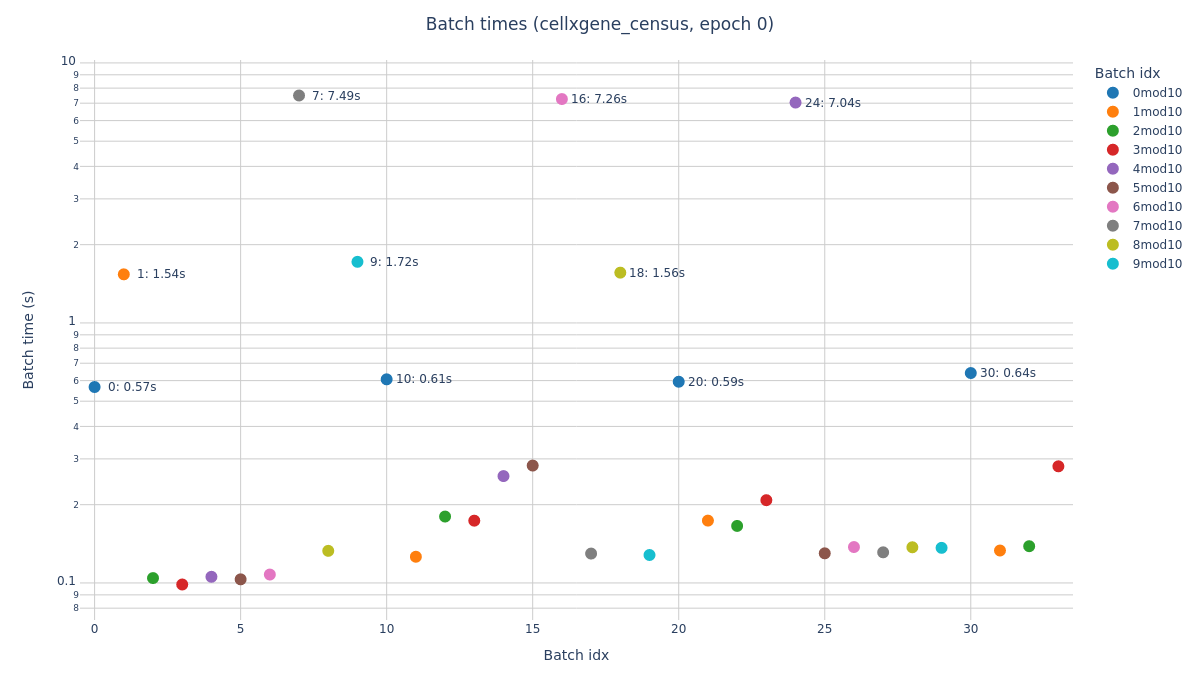

In [15]:
fig = px.scatter(
    df,
    x='idx',
    y='time',
    # text='time',
    color='res_str',
    color_discrete_sequence=default_colors,
    labels={ 'time': 'Batch time (s)', 'res_str': 'Batch idx', 'idx': 'Batch idx', },
    log_y=True,
).update_layout(
    title=dict(text=f'Batch times ({method}, epoch {epoch})'),
).update_xaxes(
    range=(-.5, len(df) - 1 + .5),
).update_traces(
    marker=dict(
        size=12,
    )
)
for idx, time in anns:
    fig.add_annotation(
        x=idx, y=log10(time),
        showarrow=False,
        text=f'{idx}: {time:.2f}s',
        xshift=37,
        #yshift=0,
    )

plot(fig, 'benchmark-batch-times', fmt='png', save=['png'], w=1200, h=700,)
#fig
#Image(fig.to_image(width=1200, height=800))